In [16]:
import pandas as pd
# from plotnine import *
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api

# import xgboost as xgb

# from statsforecast import StatsForecast
# from statsforecast.models import (
#     AutoARIMA,
#     HoltWinters,
#     AutoTheta,
#     AutoETS,
#     DynamicOptimizedTheta as DOT,
#     SeasonalNaive
# )


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

In [2]:
# Copied from https://github.com/vcerqueira
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Time delay embedding
    Time series for supervised learning
    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast
    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    X = [series.shift(i) for i in n_lags_iter]
    X = pd.concat(X, axis=1).dropna()
    X.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return X




In [9]:
tavg = pd.read_csv("new_england_tavg.csv", index_col=0, parse_dates=True,squeeze=True)
tmax = pd.read_csv("new_england_tmax.csv", index_col=0, parse_dates=True,squeeze=True)
tmin = pd.read_csv("new_england_tmin.csv", index_col=0, parse_dates=True,squeeze=True)
series = tavg
# series2 = series.diff()
# series.diff() 

C:\Users\Thinkpad user\AppData\Local\Temp\ipykernel_7700\2498935085.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  tavg = pd.read_csv("new_england_tavg.csv", index_col=0, parse_dates=True,squeeze=True)
C:\Users\Thinkpad user\AppData\Local\Temp\ipykernel_7700\2498935085.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  tmax = pd.read_csv("new_england_tmax.csv", index_col=0, parse_dates=True,squeeze=True)
C:\Users\Thinkpad user\AppData\Local\Temp\ipykernel_7700\2498935085.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  tmin = pd.read_csv("new_england_tmin.csv", index_col=0, parse_dates=True,squeeze=True)


The mean absolute error is only 2.3, thus guessing the temp a day in advance based on todays temp is actually a pretty good starting point


In [11]:
# test how well prior day predicts temp
shifted = series.shift(1).fillna(0)
shifted2 = series.shift(2).fillna(0)
shifted3 = series.shift(3).fillna(0)
shifted4 = series.shift(4).fillna(0)
shifted_min = tmin.shift(1).fillna(0)
shifted_max = tmax.shift(1).fillna(0)

momentum = shifted - shifted2
x = shifted + (momentum*0.1)
z = shifted.rolling(3).mean().fillna(0)
y = (z+x)/2

mae(tavg, x)

2.2695840820576096

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

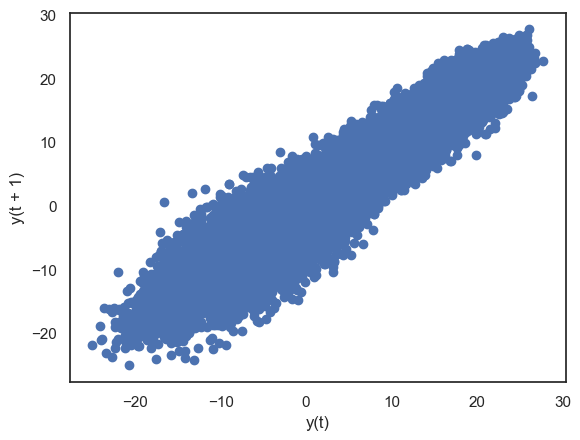

In [13]:
pd.plotting.lag_plot(series, lag=(1))


<AxesSubplot: >

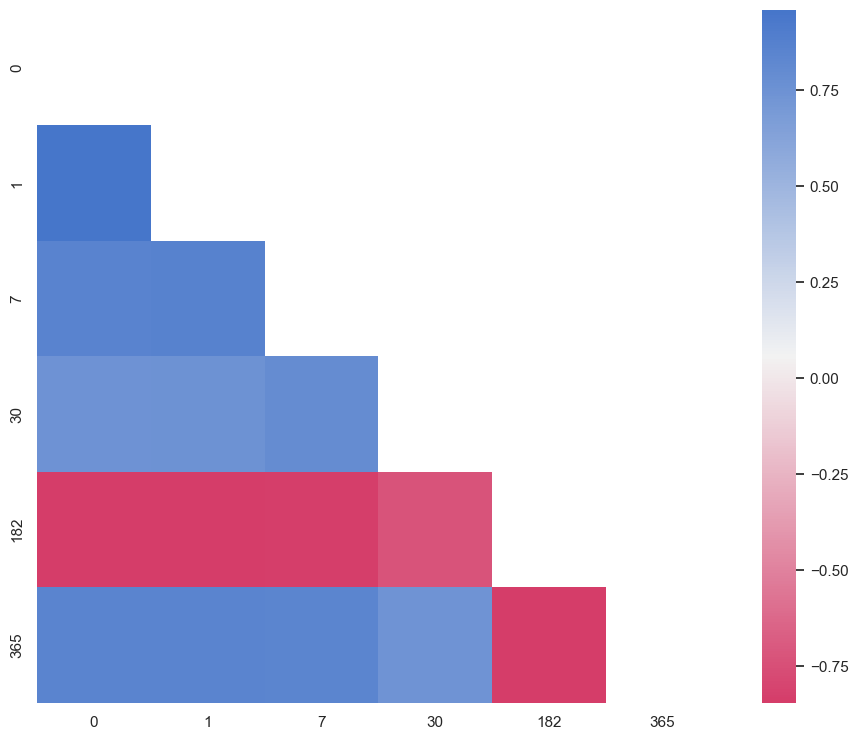

In [14]:
labels = [0,1,7,30,182,365]
correlation = pd.concat([series, series.shift(1), series.shift(7),series.shift(30),series.shift(182),series.shift(365)], axis=1)

correlation = correlation.corr(method = 'pearson')

plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(correlation, dtype=bool))
cmap = sns.diverging_palette(0, 255, sep=2, n=512, as_cmap=True)
sns.heatmap(correlation, mask=mask,cmap=cmap, xticklabels=labels, yticklabels=labels)

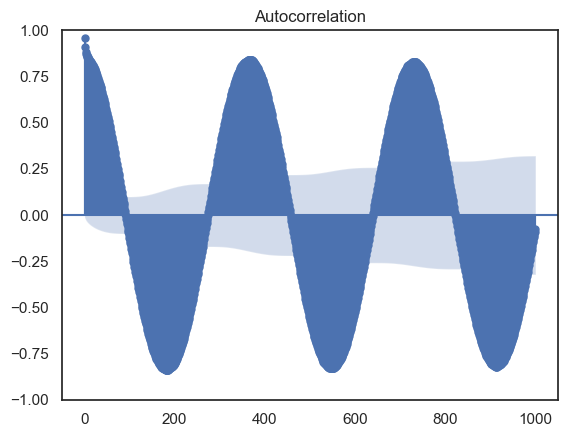

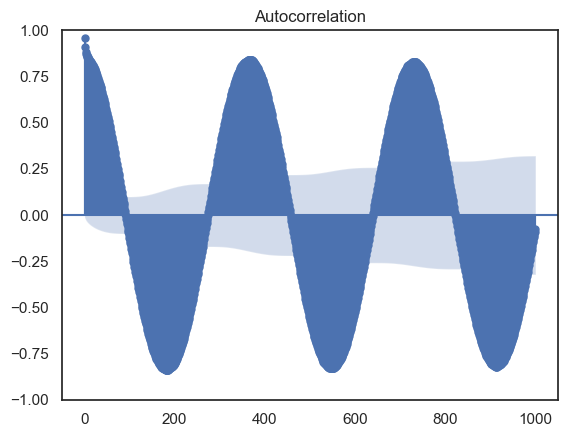

In [17]:
statsmodels.graphics.tsaplots.plot_acf(series, lags=np.arange(1,1000))

In [18]:

# applying time delay embedding
# using 3 lags (n_lags=3) to predict the next value (horizon=1)
ts = time_delay_embedding(series=series, n_lags=365, horizon=1)
ts

,measurement(t-364),measurement(t-363),measurement(t-362),measurement(t-361),measurement(t-360),measurement(t-359),measurement(t-358),measurement(t-357),measurement(t-356),measurement(t-355),...,measurement(t-8),measurement(t-7),measurement(t-6),measurement(t-5),measurement(t-4),measurement(t-3),measurement(t-2),measurement(t-1),measurement(t-0),measurement(t+1)
date,,,,,,,,,,,,,,,,,,,,,
1952-01-01,-7.01,-6.75,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,...,-4.50,-7.60,-10.36,-8.19,-11.03,-15.80,-14.57,-4.55,0.07,-0.56
1952-01-02,-6.75,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,...,-7.60,-10.36,-8.19,-11.03,-15.80,-14.57,-4.55,0.07,-0.56,1.31
1952-01-03,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,...,-10.36,-8.19,-11.03,-15.80,-14.57,-4.55,0.07,-0.56,1.31,-4.10
1952-01-04,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,-3.86,...,-8.19,-11.03,-15.80,-14.57,-4.55,0.07,-0.56,1.31,-4.10,-9.10
1952-01-05,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,-3.86,-7.59,...,-11.03,-15.80,-14.57,-4.55,0.07,-0.56,1.31,-4.10,-9.10,-12.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-2.59,-3.97,-0.09,-5.66,-3.70,-1.95,-3.38,-2.89,-3.79,-1.74,...,3.32,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11,-2.83
2021-12-28,-3.97,-0.09,-5.66,-3.70,-1.95,-3.38,-2.89,-3.79,-1.74,-2.40,...,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11,-2.83,-3.98
2021-12-29,-0.09,-5.66,-3.70,-1.95,-3.38,-2.89,-3.79,-1.74,-2.40,-2.60,...,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11,-2.83,-3.98,-1.90


In [19]:
# splitting target variable from explanatory variables
target_columns = ts.columns.str.contains('\+')
X = ts.iloc[:, ~target_columns]
y = ts['measurement(t+1)']
X

,measurement(t-364),measurement(t-363),measurement(t-362),measurement(t-361),measurement(t-360),measurement(t-359),measurement(t-358),measurement(t-357),measurement(t-356),measurement(t-355),...,measurement(t-9),measurement(t-8),measurement(t-7),measurement(t-6),measurement(t-5),measurement(t-4),measurement(t-3),measurement(t-2),measurement(t-1),measurement(t-0)
date,,,,,,,,,,,,,,,,,,,,,
1952-01-01,-7.01,-6.75,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,...,1.29,-4.50,-7.60,-10.36,-8.19,-11.03,-15.80,-14.57,-4.55,0.07
1952-01-02,-6.75,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,...,-4.50,-7.60,-10.36,-8.19,-11.03,-15.80,-14.57,-4.55,0.07,-0.56
1952-01-03,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,...,-7.60,-10.36,-8.19,-11.03,-15.80,-14.57,-4.55,0.07,-0.56,1.31
1952-01-04,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,-3.86,...,-10.36,-8.19,-11.03,-15.80,-14.57,-4.55,0.07,-0.56,1.31,-4.10
1952-01-05,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,-3.86,-7.59,...,-8.19,-11.03,-15.80,-14.57,-4.55,0.07,-0.56,1.31,-4.10,-9.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-2.59,-3.97,-0.09,-5.66,-3.70,-1.95,-3.38,-2.89,-3.79,-1.74,...,6.34,3.32,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11
2021-12-28,-3.97,-0.09,-5.66,-3.70,-1.95,-3.38,-2.89,-3.79,-1.74,-2.40,...,3.32,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11,-2.83
2021-12-29,-0.09,-5.66,-3.70,-1.95,-3.38,-2.89,-3.79,-1.74,-2.40,-2.60,...,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11,-2.83,-3.98


In [20]:

# train/test split
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.33, shuffle=False)


In [ ]:

# fitting a random forest
model = RandomForestRegressor(verbose=1)
model.fit(X_tr, y_tr)
model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:


# getting forecasts for the test set
predictions = model.predict(X_ts)


In [72]:



# computing MAE error
mae(y_ts, predictions)


2.0932675515525005

In [18]:
# df = pd.read_csv("new_england_tavg.csv")
# arima = StatsForecast(
#     models = [AutoARIMA(season_length = 365)],freq = 'D')

# arima.fit(df)
# sf.predict(h=12, level=[95])


KeyError: "None of ['unique_id'] are in the columns"

In [ ]:
# data = df
# #set frquency of index to daily
# data.index.freq = 'D'
# myorder = (1,1,1)
# myseasonal_order = (1,1,1,365)
# # add frequency parameter to SARIMAX
# model = SARIMAX(data, order=myorder, seasonal_order=myseasonal_order, freq="D")
# results = model.fit()
# print(results.summary())



# rom prophet import Prophet
# df["ds"] = df.index
# df["y"] = df["measurement"]
# df = df[["ds", "y"]]
# m = Prophet()
# m.fit(df)
# future = m.make_future_dataframe(periods=365)
# forecast = m.predict(future)
# fig1 = m.plot(forecast)
# fig2 = m.plot_components(forecast)
# plt.show()
# m.
